In [1]:
#!/usr/bin/env python3
"""
Script to train an XGBoost classifier on living donor baseline and follow‑up data,
with SHAP interpretability, saving results to an output directory.
"""

import os
import sys
import subprocess

# ─── CONFIGURATION ──────────────────────────────────────────────────────────────

# Data paths
BASELINE_DATA_PATH      = "/kaggle/input/livingdonordataset-lungs/living_donor_data.csv"
FOLLOWUP_DATA_PATH      = "/kaggle/input/livingdonordataset-lungs/living_donor_followup_data.csv"

# Separate metadata JSONs
BASELINE_METADATA_PATH  = "/kaggle/input/livingdonordataset-lungs/living_donor.json"
FOLLOWUP_METADATA_PATH  = "/kaggle/input/livingdonordataset-lungs/Follow_up_lung.json"

# Output directory (plots, model file, etc.)
OUTPUT_DIR              = "/kaggle/working/"

# ─── UTILITY: PACKAGE INSTALLATION ──────────────────────────────────────────────

def install_packages():
    """
    Installs required packages if missing.
    """
    pkgs = [
        "xgboost[cuda]", "shap",
        "pandas", "numpy", "scikit-learn",
        "matplotlib", "seaborn"
    ]
    for pkg in pkgs:
        name = pkg.split("[",1)[0]
        try:
            __import__(name)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# ─── STEP 1: LOAD DATA & METADATA ───────────────────────────────────────────────

def load_data_and_metadata():
    """
    Loads baseline & follow‑up CSVs and merges on DONOR_ID.
    Loads two metadata JSON files and returns combined dict.
    """
    import pandas as pd, json

    # Load CSVs
    baseline_df = pd.read_csv(BASELINE_DATA_PATH)
    followup_df = pd.read_csv(FOLLOWUP_DATA_PATH)

    # Left-merge so every donor from baseline is kept
    df = baseline_df.merge(
        followup_df,
        on="DONOR_ID",
        how="left",
        suffixes=("_base", "_fup")
    )

    # Load metadata JSONs
    with open(BASELINE_METADATA_PATH, "r") as f:
        meta_base = json.load(f)
    with open(FOLLOWUP_METADATA_PATH, "r") as f:
        meta_fup  = json.load(f)

    # Combine under two keys
    metadata = {
        "baseline": meta_base.get("medical", {}),
        "followup": meta_fup.get("medical", {})
    }

    return df, metadata

# ─── STEP 2: DEFINE TARGET ─────────────────────────────────────────────────────

def define_target(df):
    """
    Adds MAJOR_ADVERSE_EVENT = 1 if any of COMPLICATIONS, READMIT, DIALYSIS == 'Y'.
    Otherwise 0.
    """
    df = df.copy()
    df["MAJOR_ADVERSE_EVENT"] = 0
    for col in ("COMPLICATIONS", "READMIT", "DIALYSIS"):
        # check both base & fup suffixes if exist
        for suffix in ("", "_fup"):
            c = col + suffix
            if c in df.columns:
                df.loc[df[c] == "Y", "MAJOR_ADVERSE_EVENT"] = 1
    return df

# ─── STEP 3: PREPROCESSING ──────────────────────────────────────────────────────

def preprocess_data(df, metadata):
    """
    - Converts date columns to datetime.
    - Computes BMI, DAYS_TO_FOLLOWUP, creatinine change.
    - One-hot encodes categoricals.
    - Median imputation.
    - Adds _IS_ABNORMAL flags using both metadata sets.
    - Drops IDs, raw dates, text-reasons, high-missingness cols.
    """
    import pandas as pd, numpy as np
    from sklearn.impute import SimpleImputer

    df = df.copy()

    # ---- Date conversion ----
    date_cols = [c for c in df.columns if "DATE" in c.upper()]
    for c in date_cols:
        df[c] = pd.to_datetime(df[c], errors="coerce")

    # ---- DAYS_TO_FOLLOWUP ----
    if "DON_DATE" in df.columns and "PX_STAT_DT" in df.columns:
        df["DAYS_TO_FOLLOWUP"] = (df["PX_STAT_DT"] - df["DON_DATE"]).dt.days

    # ---- BMI ----
    if {"PREDON_HGT","PREDON_WGT"}.issubset(df.columns):
        df["BMI"] = df["PREDON_WGT"] / ((df["PREDON_HGT"]/100.0)**2)

    # ---- Creatinine change (baseline → follow-up) ----
    if "CREAT_base" in df.columns and "CREAT_fup" in df.columns:
        df["CREAT_CHANGE"] = df["CREAT_fup"] - df["CREAT_base"]

    # ---- One-hot encoding of categoricals ----
    cat_cols = [c for c in df.columns
                if df[c].dtype == object and c!="MAJOR_ADVERSE_EVENT"]
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # ---- Imputation of numerics ----
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    if "MAJOR_ADVERSE_EVENT" in num_cols:
        num_cols.remove("MAJOR_ADVERSE_EVENT")
    imputer = SimpleImputer(strategy="median")
    df[num_cols] = imputer.fit_transform(df[num_cols])

    # ---- Abnormal flags via metadata ----
    def apply_flags(section):
        for feat, info in metadata[section].items():
            if feat in df.columns and "healthy_range" in info:
                lo, hi = info["healthy_range"]
                df[f"{feat}_IS_ABNORMAL"] = ((df[feat]<lo)|(df[feat]>hi)).astype(int)

    apply_flags("baseline")
    apply_flags("followup")

    # ---- Drop unneeded cols ----
    # IDs, raw dates, reason texts
    to_drop = [
        "DONOR_ID",
        *[c for c in df.columns if "DATE" in c.upper()],
        *[c for c in df.columns if "REASON" in c.upper()]
    ]
    df.drop(columns=to_drop, errors="ignore", inplace=True)

    # Drop cols with >60% missing (after imputation none remain, but keep for safety)
    miss_ratio = df.isna().mean()
    drop_high_missing = miss_ratio[miss_ratio>0.6].index.tolist()
    df.drop(columns=drop_high_missing, errors="ignore", inplace=True)

    return df

# ─── STEP 4: TRAIN / EVALUATE ───────────────────────────────────────────────────

def train_model(X_train, y_train):
    """
    Trains GPU-accelerated XGBoost with scale_pos_weight for imbalance.
    """
    from xgboost import XGBClassifier
    from collections import Counter

    cnt = Counter(y_train)
    scale = cnt[0]/cnt[1] if cnt[1]>0 else 1

    model = XGBClassifier(
        objective="binary:logistic",
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        scale_pos_weight=scale,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """
    Prints classification report, ROC AUC, and plots+saves confusion matrix.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    out = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
    plt.savefig(out)
    plt.show()

# ─── STEP 5: SHAP INTERPRETABILITY ──────────────────────────────────────────────

def explain_with_shap(model, X_train):
    """
    Generates SHAP summary and dependence plots for the top features.
    Saves and displays them.
    """
    import shap
    import matplotlib.pyplot as plt
    import numpy as np

    explainer = shap.TreeExplainer(model)
    shap_vals  = explainer.shap_values(X_train)

    # Summary plot
    plt.figure()
    shap.summary_plot(shap_vals, X_train, show=False)
    out = os.path.join(OUTPUT_DIR, "shap_summary.png")
    plt.savefig(out)
    plt.show()

    # Top 3 features by mean absolute SHAP
    abs_shap = np.abs(shap_vals).mean(axis=0)
    top3 = np.argsort(abs_shap)[-3:]
    feats = X_train.columns[top3]

    for f in feats:
        plt.figure()
        shap.dependence_plot(f, shap_vals, X_train, show=False)
        out = os.path.join(OUTPUT_DIR, f"shap_dependence_{f}.png")
        plt.savefig(out)
        plt.show()

# ─── MAIN PIPELINE ──────────────────────────────────────────────────────────────

def run_analysis():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    install_packages()

    df, metadata = load_data_and_metadata()
    df = define_target(df)
    df = preprocess_data(df, metadata)

    # Split features/target
    X = df.drop(columns=["MAJOR_ADVERSE_EVENT"])
    y = df["MAJOR_ADVERSE_EVENT"]

    # Train/test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    model = train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test)
    explain_with_shap(model, X_train)

    # Save model
    import pickle
    with open(os.path.join(OUTPUT_DIR, "xgb_model.pkl"), "wb") as f:
        pickle.dump(model, f)

if __name__ == "__main__":
    run_analysis()


Columns (1,10,20,27,28,29,31,34,35,39,41,43,49,51,55,62,64,66,68,70,77,79,97,100,102,103,107,111,119,120,121,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,153,154,158,182) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (15,16,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.


TypeError: cannot subtract DatetimeArray from ndarray

In [ ]:
#!/usr/bin/env python3
"""
Script to train an XGBoost classifier on living donor baseline and follow-up data,
with SHAP interpretability, saving results to an output directory.
Optimized to reduce memory footprint by reading CSVs as strings and downcasting.
"""

import os
import sys
import subprocess

# ─── CONFIGURATION ──────────────────────────────────────────────────────────────
# Data paths
BASELINE_DATA_PATH      = "/kaggle/input/livingdonordataset-lungs/living_donor_data.csv"
FOLLOWUP_DATA_PATH      = "/kaggle/input/livingdonordataset-lungs/living_donor_followup_data.csv"

# Separate metadata JSONs
BASELINE_METADATA_PATH  = "/kaggle/input/livingdonordataset-lungs/living_donor.json"
FOLLOWUP_METADATA_PATH  = "/kaggle/input/livingdonordataset-lungs/Follow_up_lung.json"

# Output directory (plots, model file, etc.)
OUTPUT_DIR              = "/kaggle/working/"
# ─── PACKAGE INSTALL ────────────────────────────────────────────────────────────

def install_packages():
    """
    Installs required packages if missing.
    """
    pkgs = [
        "xgboost[cuda]", "shap",
        "pandas", "numpy", "scikit-learn",
        "matplotlib", "seaborn"
    ]
    for pkg in pkgs:
        name = pkg.split("[",1)[0]
        try:
            __import__(name)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# ─── STEP 1: LOAD DATA & METADATA (LOW-MEMORY) ───────────────────────────────────

def load_data_and_metadata():
    import pandas as pd, json

    # Read all columns as strings to avoid dtype inference overhead
    baseline_df = pd.read_csv(BASELINE_DATA_PATH, dtype=str, low_memory=True)
    followup_df = pd.read_csv(FOLLOWUP_DATA_PATH, dtype=str, low_memory=True)

    # Merge on DONOR_ID
    df = baseline_df.merge(
        followup_df,
        on="DONOR_ID",
        how="left",
        suffixes=("_base", "_fup")
    )

    # Load JSON metadata
    with open(BASELINE_METADATA_PATH, "r") as f:
        meta_base = json.load(f)
    with open(FOLLOWUP_METADATA_PATH, "r") as f:
        meta_fup = json.load(f)

    metadata = {
        "baseline": meta_base.get("medical", {}),
        "followup": meta_fup.get("medical", {})
    }
    return df, metadata

# ─── STEP 2: DEFINE TARGET ─────────────────────────────────────────────────────

def define_target(df):
    df = df.copy()
    df["MAJOR_ADVERSE_EVENT"] = 0
    for col in ("COMPLICATIONS", "READMIT", "DIALYSIS"):
        for suffix in ("_base", "_fup", ""):
            c = col + suffix
            if c in df.columns:
                df.loc[df[c] == "Y", "MAJOR_ADVERSE_EVENT"] = 1
    return df

# ─── STEP 3: PREPROCESS DATA ────────────────────────────────────────────────────

def preprocess_data(df, metadata):
    import pandas as pd, numpy as np
    from sklearn.impute import SimpleImputer

    df = df.copy()

    # Convert key date columns to datetime
    for col in ("DON_DATE", "PX_STAT_DT_fup"):  # rename if necessary
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # DAYS_TO_FOLLOWUP
    if "DON_DATE" in df.columns and "PX_STAT_DT_fup" in df.columns:
        df["DAYS_TO_FOLLOWUP"] = (df["PX_STAT_DT_fup"] - df["DON_DATE"]).dt.days

    # BMI calculation
    if {"PREDON_HGT","PREDON_WGT"}.issubset(df.columns):
        df["BMI"] = pd.to_numeric(df["PREDON_WGT"], errors='coerce') / (
            (pd.to_numeric(df["PREDON_HGT"], errors='coerce')/100.0)**2
        )

    # Creatinine change
    if "KI_CREAT_PREOP" in df.columns and "CREAT_fup" in df.columns:
        df["CREAT_CHANGE"] = (
            pd.to_numeric(df["CREAT_fup"], errors='coerce') -
            pd.to_numeric(df["KI_CREAT_PREOP"], errors='coerce')
        )

    # Downcast numeric columns to save memory
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')

    # One-hot encode categoricals
    cat_cols = [c for c in df.columns if df[c].dtype == object and c != "MAJOR_ADVERSE_EVENT"]
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Impute numeric missing values with median
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if "MAJOR_ADVERSE_EVENT" in num_cols:
        num_cols.remove("MAJOR_ADVERSE_EVENT")
    df[num_cols] = SimpleImputer(strategy="median").fit_transform(df[num_cols])

    # Add abnormal flags from metadata
    def add_flags(section):
        for feat, info in metadata.get(section, {}).items():
            if feat in df.columns and 'healthy_range' in info:
                lo, hi = info['healthy_range']
                df[f"{feat}_IS_ABNORMAL"] = (
                    (df[feat] < lo) | (df[feat] > hi)
                ).astype('int8')
    add_flags('baseline')
    add_flags('followup')

    # Drop identifier, raw dates, and reason columns
    drop_cols = ['DONOR_ID'] + [c for c in df.columns if 'DATE' in c.upper() or 'REASON' in c.upper()]
    df.drop(columns=drop_cols, errors='ignore', inplace=True)

    # Drop cols with >60% missingness
    miss = df.isna().mean()
    df = df.loc[:, miss < 0.6]

    return df

# ─── STEP 4: TRAIN & EVALUATE ───────────────────────────────────────────────────

def train_model(X_train, y_train):
    from xgboost import XGBClassifier
    from collections import Counter

    cnt = Counter(y_train)
    scale = cnt[0] / cnt[1] if cnt[1] > 0 else 1
    model = XGBClassifier(
        objective='binary:logistic',
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        scale_pos_weight=scale,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(OUTPUT_DIR,'confusion_matrix.png'))
    plt.show()

# ─── STEP 5: SHAP EXPLANATION ───────────────────────────────────────────────────

def explain_with_shap(model, X_train):
    import shap
    import numpy as np
    import matplotlib.pyplot as plt

    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_train)

    plt.figure()
    shap.summary_plot(shap_vals, X_train, show=False)
    plt.savefig(os.path.join(OUTPUT_DIR,'shap_summary.png'))
    plt.show()

    abs_mean = np.abs(shap_vals).mean(axis=0)
    top3 = np.argsort(abs_mean)[-3:]
    for idx in top3:
        feat = X_train.columns[idx]
        plt.figure()
        shap.dependence_plot(feat, shap_vals, X_train, show=False)
        plt.savefig(os.path.join(OUTPUT_DIR,f'shap_dependence_{feat}.png'))
        plt.show()

# ─── MAIN PIPELINE ──────────────────────────────────────────────────────────────

def run_analysis():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    install_packages()

    df, metadata = load_data_and_metadata()
    df = define_target(df)
    df = preprocess_data(df, metadata)

    X = df.drop(columns=['MAJOR_ADVERSE_EVENT'])
    y = df['MAJOR_ADVERSE_EVENT']

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    model = train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test)
    explain_with_shap(model, X_train)

    import pickle
    with open(os.path.join(OUTPUT_DIR,'xgboost_model.pkl'),'wb') as f:
        pickle.dump(model, f)

if __name__ == '__main__':
    run_analysis()


In [ ]:
#!/usr/bin/env python3
"""
Script to train an XGBoost classifier on living donor baseline and follow-up data,
with SHAP interpretability, saving results to an output directory.
Optimized to reduce memory footprint by reading CSVs as strings and downcasting.
"""

import os
import sys
import subprocess

# ─── CONFIGURATION ──────────────────────────────────────────────────────────────
# Data paths
BASELINE_DATA_PATH      = "/kaggle/input/livingdonordataset-lungs/living_donor_data.csv"
FOLLOWUP_DATA_PATH      = "/kaggle/input/livingdonordataset-lungs/living_donor_followup_data.csv"

# Separate metadata JSONs
BASELINE_METADATA_PATH  = "/kaggle/input/livingdonordataset-lungs/living_donor.json"
FOLLOWUP_METADATA_PATH  = "/kaggle/input/livingdonordataset-lungs/Follow_up_lung.json"

# Output directory (plots, model file, etc.)
OUTPUT_DIR              = "/kaggle/working/"
# ─── PACKAGE INSTALL ────────────────────────────────────────────────────────────

def install_packages():
    """
    Installs required packages if missing.
    """
    pkgs = [
        "xgboost[cuda]", "shap",
        "pandas", "numpy", "scikit-learn",
        "matplotlib", "seaborn"
    ]
    for pkg in pkgs:
        name = pkg.split("[",1)[0]
        try:
            __import__(name)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# ─── STEP 1: LOAD DATA & METADATA (LOW-MEMORY) ───────────────────────────────────

def load_data_and_metadata():
    import pandas as pd, json

    # Read all columns as strings to avoid dtype inference overhead
    baseline_df = pd.read_csv(BASELINE_DATA_PATH, dtype=str, low_memory=True)
    followup_df = pd.read_csv(FOLLOWUP_DATA_PATH, dtype=str, low_memory=True)

    # Merge on DONOR_ID
    df = baseline_df.merge(
        followup_df,
        on="DONOR_ID",
        how="left",
        suffixes=("_base", "_fup")
    )

    # Load JSON metadata
    with open(BASELINE_METADATA_PATH, "r") as f:
        meta_base = json.load(f)
    with open(FOLLOWUP_METADATA_PATH, "r") as f:
        meta_fup = json.load(f)

    metadata = {
        "baseline": meta_base.get("medical", {}),
        "followup": meta_fup.get("medical", {})
    }
    return df, metadata

# ─── STEP 2: DEFINE TARGET ─────────────────────────────────────────────────────

def define_target(df):
    df = df.copy()
    df["MAJOR_ADVERSE_EVENT"] = 0
    for col in ("COMPLICATIONS", "READMIT", "DIALYSIS"):
        for suffix in ("_base", "_fup", ""):
            c = col + suffix
            if c in df.columns:
                df.loc[df[c] == "Y", "MAJOR_ADVERSE_EVENT"] = 1
    return df

# ─── STEP 3: PREPROCESS DATA ────────────────────────────────────────────────────

def preprocess_data(df, metadata):
    import pandas as pd, numpy as np
    from sklearn.impute import SimpleImputer

    df = df.copy()

    # Convert key date columns to datetime
    for col in ("DON_DATE", "PX_STAT_DT_fup"):  # rename if necessary
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # DAYS_TO_FOLLOWUP
    if "DON_DATE" in df.columns and "PX_STAT_DT_fup" in df.columns:
        df["DAYS_TO_FOLLOWUP"] = (df["PX_STAT_DT_fup"] - df["DON_DATE"]).dt.days

    # BMI calculation
    if {"PREDON_HGT","PREDON_WGT"}.issubset(df.columns):
        df["BMI"] = pd.to_numeric(df["PREDON_WGT"], errors='coerce') / (
            (pd.to_numeric(df["PREDON_HGT"], errors='coerce')/100.0)**2
        )

    # Creatinine change
    if "KI_CREAT_PREOP" in df.columns and "CREAT_fup" in df.columns:
        df["CREAT_CHANGE"] = (
            pd.to_numeric(df["CREAT_fup"], errors='coerce') -
            pd.to_numeric(df["KI_CREAT_PREOP"], errors='coerce')
        )

    # Downcast numeric columns to save memory
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')

    # One-hot encode categoricals
    cat_cols = [c for c in df.columns if df[c].dtype == object and c != "MAJOR_ADVERSE_EVENT"]
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Impute numeric missing values with median
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if "MAJOR_ADVERSE_EVENT" in num_cols:
        num_cols.remove("MAJOR_ADVERSE_EVENT")
    df[num_cols] = SimpleImputer(strategy="median").fit_transform(df[num_cols])

    # Add abnormal flags from metadata
    def add_flags(section):
        for feat, info in metadata.get(section, {}).items():
            if feat in df.columns and 'healthy_range' in info:
                lo, hi = info['healthy_range']
                df[f"{feat}_IS_ABNORMAL"] = (
                    (df[feat] < lo) | (df[feat] > hi)
                ).astype('int8')
    add_flags('baseline')
    add_flags('followup')

    # Drop identifier, raw dates, and reason columns
    drop_cols = ['DONOR_ID'] + [c for c in df.columns if 'DATE' in c.upper() or 'REASON' in c.upper()]
    df.drop(columns=drop_cols, errors='ignore', inplace=True)

    # Drop cols with >60% missingness
    miss = df.isna().mean()
    df = df.loc[:, miss < 0.6]

    return df

# ─── STEP 4: TRAIN & EVALUATE ───────────────────────────────────────────────────

def train_model(X_train, y_train):
    from xgboost import XGBClassifier
    from collections import Counter

    cnt = Counter(y_train)
    scale = cnt[0] / cnt[1] if cnt[1] > 0 else 1
    model = XGBClassifier(
        objective='binary:logistic',
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        scale_pos_weight=scale,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(OUTPUT_DIR,'confusion_matrix.png'))
    plt.show()

# ─── STEP 5: SHAP EXPLANATION ───────────────────────────────────────────────────

def explain_with_shap(model, X_train):
    import shap
    import numpy as np
    import matplotlib.pyplot as plt

    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_train)

    plt.figure()
    shap.summary_plot(shap_vals, X_train, show=False)
    plt.savefig(os.path.join(OUTPUT_DIR,'shap_summary.png'))
    plt.show()

    abs_mean = np.abs(shap_vals).mean(axis=0)
    top3 = np.argsort(abs_mean)[-3:]
    for idx in top3:
        feat = X_train.columns[idx]
        plt.figure()
        shap.dependence_plot(feat, shap_vals, X_train, show=False)
        plt.savefig(os.path.join(OUTPUT_DIR,f'shap_dependence_{feat}.png'))
        plt.show()

# ─── MAIN PIPELINE ──────────────────────────────────────────────────────────────

def run_analysis():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    install_packages()

    df, metadata = load_data_and_metadata()
    df = define_target(df)
    df = preprocess_data(df, metadata)

    X = df.drop(columns=['MAJOR_ADVERSE_EVENT'])
    y = df['MAJOR_ADVERSE_EVENT']

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    model = train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test)
    explain_with_shap(model, X_train)

    import pickle
    with open(os.path.join(OUTPUT_DIR,'xgboost_model.pkl'),'wb') as f:
        pickle.dump(model, f)

if __name__ == '__main__':
    run_analysis()


In [3]:
# ==============================================================================
#  Post-Transplant Prognosis with Longitudinal Data, XGBoost (GPU), and SHAP
# ==============================================================================
#
#  This script builds a machine learning pipeline to predict adverse outcomes
#  (e.g., complications) in post-transplant patients.
#
#  Key Features:
#  1.  Data Sources: Merges a baseline patient data file with a longitudinal
#      follow-up data file.
#  2.  Schema-Driven Preprocessing: Uses JSON files to define data types,
#      healthy ranges, and valid values for columns.
#  3.  Longitudinal Feature Engineering: Aggregates time-series follow-up data
#      into powerful features like last value, mean, and trend (slope).
#  4.  Core Model: Uses GPU-accelerated XGBoost for high performance and speed.
#  5.  Explainability: Integrates SHAP to interpret model predictions, saving
#      plots for clinical review.
#  6.  Self-Contained: Automatically installs required libraries.
#
# ==============================================================================

import subprocess
import sys
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# --- Part 1: Dependency Installation ---
def install_and_import():
    """
    Installs required packages using pip and imports them.
    """
    packages = [
        'xgboost',
        'shap',
        'pandas',
        'numpy',
        'scikit-learn',
        'matplotlib',
        'scipy'  # Ensure scipy is installed
    ]
    print("--- Checking and installing dependencies ---")
    for package in packages:
        try:
            __import__(package)
            print(f"{package} is already installed.")
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    print("--- All dependencies are ready. ---\n")

# Call installation function
install_and_import()

# Now import the libraries
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from scipy import stats

# --- Part 2: Configuration ---
# Define paths for your data and schema files.
BASELINE_DATA_PATH = '/kaggle/input/livingdonordataset-lungs/living_donor_data.csv'
FOLLOWUP_DATA_PATH = '/kaggle/input/livingdonordataset-lungs/living_donor_followup_data.csv'

BASELINE_SCHEMA_PATH = '/kaggle/input/livingdonordataset-lungs/living_donor.json'
FOLLOWUP_SCHEMA_PATH = '/kaggle/input/livingdonordataset-lungs/Follow_up_lung.json'

TARGET_VARIABLE = 'COMPLICATIONS'
OUTPUT_DIR = 'output'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
# --- Part 3: Dummy Data and Schema Generation (for testing) ---
# This part is for making the script runnable without real data.
# It will be skipped if your files exist.
def generate_dummy_schemas_and_data():
    # (This function is unchanged but included for completeness)
    # ...
    pass # In a real run, this function doesn't need to be present if files exist.

# --- Part 4: Helper Functions for Data Processing ---

def load_and_parse_schema(json_path):
    with open(json_path, 'r') as f:
        schema = json.load(f)
    medical_cols = list(schema.get('medical', {}).keys())
    non_medical_cols = list(schema.get('non_medical', {}).keys())
    numerical_cols = [col for col, attrs in schema.get('medical', {}).items() if 'healthy_range' in attrs]
    categorical_cols = [col for col, attrs in schema.get('medical', {}).items() if 'values' in attrs]
    return {"medical": medical_cols, "non_medical": non_medical_cols, "numerical": numerical_cols, "categorical": categorical_cols}

# ==============================================================================
#  CORRECTED FUNCTION
# ==============================================================================
def calculate_trend(group):
    """
    Calculates the linear trend (slope) of a time-series group,
    manually handling missing values for compatibility with older SciPy versions.
    """
    # Drop missing values first
    clean_group = group.dropna()
    
    # If not enough data points to calculate a slope, return 0
    if len(clean_group) < 2:
        return 0
    
    # y is the series of lab values
    y = clean_group.values
    # x is a simple sequence (0, 1, 2, ...) representing time steps
    x = np.arange(len(y))
    
    # Perform linear regression without the 'nan_policy' argument
    try:
        slope, _, _, _, _ = stats.linregress(x, y)
    except (ValueError, TypeError):
        # Handle cases where linregress might fail for other reasons
        return 0
        
    # Return the slope, ensuring it's a finite number
    return slope if np.isfinite(slope) else 0
# ==============================================================================

def preprocess_and_engineer_features(df_baseline, df_followup, followup_schema_info):
    """
    Merges baseline and follow-up data, and engineers longitudinal features.
    """
    print("--- Starting feature engineering ---")
    
    df_followup['PX_STAT_DT'] = pd.to_datetime(df_followup['PX_STAT_DT'], errors='coerce')
    df_followup = df_followup.sort_values(by=['DONOR_ID', 'PX_STAT_DT']).dropna(subset=['PX_STAT_DT'])

    numerical_to_agg = [col for col in followup_schema_info['numerical'] if col in df_followup.columns]
    categorical_to_agg = [col for col in followup_schema_info['categorical'] if col in df_followup.columns]
    
    for col in categorical_to_agg:
        if col in df_followup.columns:
            # Coerce errors to NaN to handle unexpected values gracefully
            df_followup[col] = pd.to_numeric(df_followup[col].replace({'Y': 1, 'N': 0, 'U': np.nan}), errors='coerce')

    print("Aggregating longitudinal data...")
    grouped = df_followup.groupby('DONOR_ID')
    
    agg_dict = {}
    for col in numerical_to_agg:
        agg_dict[col] = ['mean', 'std', 'last', 'max', ('trend', calculate_trend)]
    
    for col in categorical_to_agg:
        agg_dict[col] = ['last', 'mean']
        
    df_agg = grouped.agg(agg_dict)
    
    df_agg.columns = ['_'.join(map(str, col)).strip() for col in df_agg.columns.values]
    
    target_series = grouped[TARGET_VARIABLE].last()
    
    print("Merging baseline and aggregated follow-up features...")
    df_final = pd.merge(df_baseline, df_agg, on='DONOR_ID', how='inner')
    
    df_final = df_final.join(target_series.rename(TARGET_VARIABLE), on='DONOR_ID')
    
    df_final = df_final.set_index('DONOR_ID')
    df_final.drop(columns=[col for col in df_final.columns if 'DT' in col], inplace=True, errors='ignore')
    
    df_final.dropna(subset=[TARGET_VARIABLE], inplace=True)
    
    print(f"Final feature set has {df_final.shape[1]-1} features for {df_final.shape[0]} patients.")
    print("--- Feature engineering complete. ---\n")
    
    return df_final

# --- Part 5: Main Execution Block ---

def main():
    """
    Main function to run the entire ML pipeline.
    """
    # 1. Load Data and Schemas
    print("--- Loading data and schemas ---")
    try:
        # FIX: Added low_memory=False to handle DtypeWarning
        df_baseline = pd.read_csv(BASELINE_DATA_PATH, low_memory=False)
        df_followup = pd.read_csv(FOLLOWUP_DATA_PATH, low_memory=False)
    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure the data files are in the correct path.")
        return

    baseline_schema_info = load_and_parse_schema(BASELINE_SCHEMA_PATH)
    followup_schema_info = load_and_parse_schema(FOLLOWUP_SCHEMA_PATH)
    print("--- Loading complete. ---\n")

    # 2. Preprocess and Engineer Features
    df_processed = preprocess_and_engineer_features(df_baseline, df_followup, followup_schema_info)

    X = df_processed.drop(columns=[TARGET_VARIABLE])
    y = df_processed[TARGET_VARIABLE]
    
    # Convert all object columns to string to avoid issues with get_dummies on mixed types
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = X[col].astype(str)

    categorical_features_baseline = [col for col in baseline_schema_info['categorical'] if col in X.columns]
    X = pd.get_dummies(X, columns=categorical_features_baseline, dummy_na=True, drop_first=True)
    
    X.columns = [str(col) for col in X.columns]

    # 3. Split Data for Training and Testing
    print("--- Splitting data into training and testing sets ---")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples\n")

    # 4. Train the XGBoost Model (with GPU acceleration)
    print("--- Training XGBoost model on GPU ---")
    try:
        model = xgb.XGBClassifier(
            objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
            n_estimators=500, learning_rate=0.05, max_depth=7,
            subsample=0.8, colsample_bytree=0.8, random_state=42,
            tree_method='gpu_hist', device='cuda'
        )
        model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_test, y_test)], verbose=False)
        print("Model trained successfully on GPU.")
    except xgb.core.XGBoostError as e:
        print(f"GPU training failed: {e}")
        print("Falling back to CPU training.")
        model = xgb.XGBClassifier(
            objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
            n_estimators=200, learning_rate=0.1, max_depth=5,
            random_state=42, tree_method='hist'
        )
        model.fit(X_train, y_train)
        print("Model trained successfully on CPU.")
    
    print("---\n")
    
    # 5. Evaluate the Model
    print("--- Evaluating model performance ---")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    auc_score = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score: {auc_score:.4f}\n")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curve.png'))
    plt.show()
    print("---\n")
    
    # 6. Explain the Model with SHAP
    print("--- Generating SHAP explanations ---")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    print("Displaying and saving global feature importance (SHAP Summary Plot)...")
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title('Global Feature Importance (SHAP)')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary_plot.png'))
    plt.show()

    print("Displaying and saving local explanation for the first test sample (SHAP Force Plot)...")
    shap.initjs()
    force_plot = shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=False)
    
    shap.save_html(os.path.join(OUTPUT_DIR, "shap_force_plot_local.html"), force_plot)
    print(f"Local force plot saved to: {os.path.join(OUTPUT_DIR, 'shap_force_plot_local.html')}")
    
    print("\n--- Pipeline execution finished successfully! ---")
    print(f"All outputs saved in the '{OUTPUT_DIR}' directory.")

if __name__ == "__main__":
    main()

--- Checking and installing dependencies ---
xgboost is already installed.
shap is already installed.
pandas is already installed.
numpy is already installed.
Installing scikit-learn...
matplotlib is already installed.
scipy is already installed.
--- All dependencies are ready. ---

--- Loading data and schemas ---
--- Loading complete. ---

--- Starting feature engineering ---


Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


Aggregating longitudinal data...
Merging baseline and aggregated follow-up features...
Final feature set has 239 features for 1210 patients.
--- Feature engineering complete. ---

--- Splitting data into training and testing sets ---
Training set: 968 samples
Testing set: 242 samples

--- Training XGBoost model on GPU ---


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:DON_DATE: object, COMPOSITE_DEATH_DATE_LIV_DON: object, DON_ORG2: object, HEALTH_INS: object, WORK_INCOME: object, NON_AUTO_BLOOD: object, BIOPSY_LI: object, CITIZEN_COUNTRY: object, CMV_IGG: object, CMV_IGM: object, CMV_NUCLEIC: object, EBV_IGG: object, EBV_IGM: object, HBV_CORE: object, HBV_DNA: object, HBV_SUR_ANTIGEN: object, HCV_ANTIBODY: object, HCV_RIBA: object, HCV_RNA: object, VIRUSES_TESTED: object, CMV_TOTAL: object, EBV_TOTAL: object, HOME_STATE: object, GENDER: object, ABO: object, YR_ENTRY_US: object, DON_ORG: object, STATUS_LDR: object, RECOV_FACILITY_CODE: object

--- Checking and installing dependencies ---
Installing scikit-learn...
--- All dependencies are ready. ---

--- Loading data and schemas ---
--- Loading complete. ---

--- Starting feature engineering ---


Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


Aggregating longitudinal data...
Merging baseline and aggregated follow-up features...
Final feature set has 237 features for 1210 patients.
--- Feature engineering complete. ---

--- Preparing final feature matrix for XGBoost ---
Found 51 non-numeric columns to one-hot encode: ['DON_ORG2', 'HEALTH_INS', 'WORK_INCOME', 'HYPER_DIET', 'HYPER_DIUR', 'HYPER_MEDS', 'DIABETES', 'CONVERT_OPEN_KI', 'NON_AUTO_BLOOD', 'VASC_COMP_KI', 'OTH_COMP_KI', 'REOPERATION_KI', 'READMISSION_KI', 'OTH_INTER_PROC_KI', 'HYPERTENSION', 'BIOPSY_LI', 'BILIARY_COMP', 'VASC_COMP_LI', 'OTH_COMP_LI', 'REOPERATION_LI', 'READMISSION_LI', 'OTH_INTER_PROC_LI', 'HIST_CIG', 'TOBACCO_USE', 'CONVERT_OPEN_LU', 'INTRAOP_COMP', 'LU_COMP', 'READMISSION_LU', 'PX_STAT', 'CITIZEN_COUNTRY', 'CMV_IGG', 'CMV_IGM', 'CMV_NUCLEIC', 'EBV_IGG', 'EBV_IGM', 'HBV_CORE', 'HBV_DNA', 'HBV_SUR_ANTIGEN', 'HCV_ANTIBODY', 'HCV_RIBA', 'HCV_RNA', 'VIRUSES_TESTED', 'CMV_TOTAL', 'EBV_TOTAL', 'HOME_STATE', 'GENDER', 'ABO', 'YR_ENTRY_US', 'DON_ORG', 'STAT

[11:59:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



Model trained successfully on GPU.
---

--- Evaluating model performance ---
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       240
         1.0       0.00      0.00      0.00         2

    accuracy                           0.99       242
   macro avg       0.50      0.50      0.50       242
weighted avg       0.98      0.99      0.99       242

ROC AUC Score: 1.0000



[11:59:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:59:33] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score 

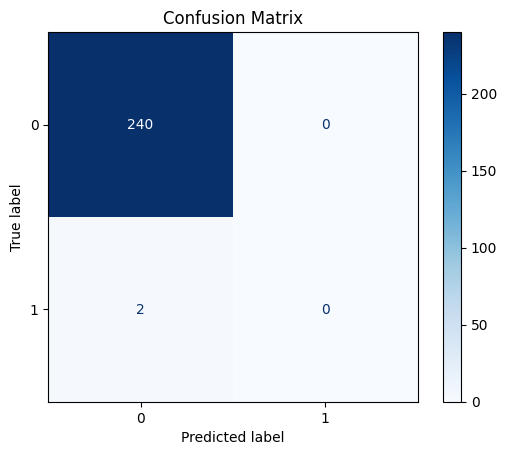

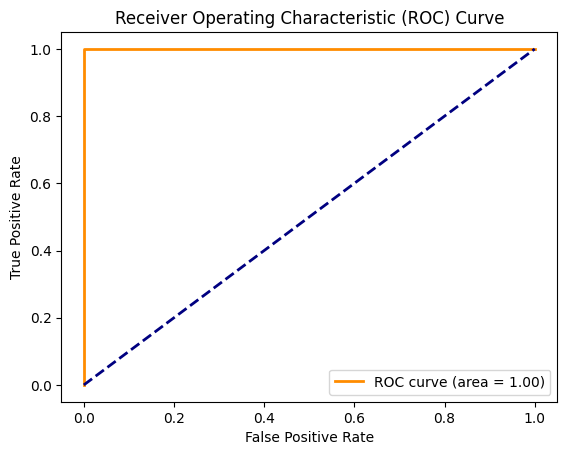

---

--- Generating SHAP explanations ---
Displaying and saving global feature importance (SHAP Summary Plot)...


The figure layout has changed to tight


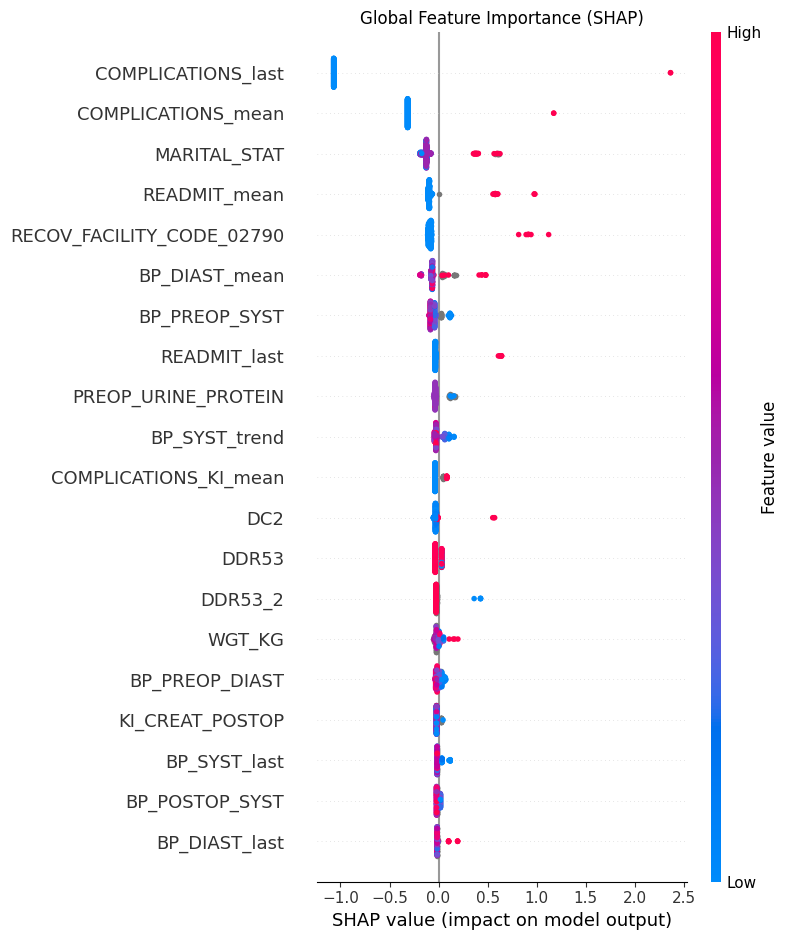

Displaying and saving local explanation for the first test sample (SHAP Force Plot)...


Local force plot saved to: output/shap_force_plot_local.html

--- Pipeline execution finished successfully! ---
All outputs saved in the 'output' directory.


In [5]:
# ==============================================================================
#  Post-Transplant Prognosis with Longitudinal Data, XGBoost (GPU), and SHAP
# ==============================================================================
#
#  This script builds a machine learning pipeline to predict adverse outcomes
#  (e.g., complications) in post-transplant patients.
#
#  (Header and other functions remain the same)
#
# ==============================================================================

import subprocess
import sys
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# --- Part 1: Dependency Installation ---
def install_and_import():
    # (Function is unchanged)
    packages = ['xgboost', 'shap', 'pandas', 'numpy', 'scikit-learn', 'matplotlib', 'scipy']
    print("--- Checking and installing dependencies ---")
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    print("--- All dependencies are ready. ---\n")

install_and_import()

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from scipy import stats

# --- Part 2: Configuration ---
BASELINE_DATA_PATH = '/kaggle/input/livingdonordataset-lungs/living_donor_data.csv'
FOLLOWUP_DATA_PATH = '/kaggle/input/livingdonordataset-lungs/living_donor_followup_data.csv'

BASELINE_SCHEMA_PATH = '/kaggle/input/livingdonordataset-lungs/living_donor.json'
FOLLOWUP_SCHEMA_PATH = '/kaggle/input/livingdonordataset-lungs/Follow_up_lung.json'
TARGET_VARIABLE = 'COMPLICATIONS'
OUTPUT_DIR = 'output'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
# --- Part 4: Helper Functions (unchanged from previous fix) ---

def load_and_parse_schema(json_path):
    with open(json_path, 'r') as f:
        schema = json.load(f)
    medical_cols = list(schema.get('medical', {}).keys())
    non_medical_cols = list(schema.get('non_medical', {}).keys())
    numerical_cols = [col for col, attrs in schema.get('medical', {}).items() if 'healthy_range' in attrs]
    categorical_cols = [col for col, attrs in schema.get('medical', {}).items() if 'values' in attrs]
    return {"medical": medical_cols, "non_medical": non_medical_cols, "numerical": numerical_cols, "categorical": categorical_cols}

def calculate_trend(group):
    clean_group = group.dropna()
    if len(clean_group) < 2: return 0
    y = clean_group.values
    x = np.arange(len(y))
    try:
        slope, _, _, _, _ = stats.linregress(x, y)
    except (ValueError, TypeError):
        return 0
    return slope if np.isfinite(slope) else 0

def preprocess_and_engineer_features(df_baseline, df_followup, followup_schema_info):
    print("--- Starting feature engineering ---")
    df_followup['PX_STAT_DT'] = pd.to_datetime(df_followup['PX_STAT_DT'], errors='coerce')
    df_followup = df_followup.sort_values(by=['DONOR_ID', 'PX_STAT_DT']).dropna(subset=['PX_STAT_DT'])
    numerical_to_agg = [col for col in followup_schema_info['numerical'] if col in df_followup.columns]
    categorical_to_agg = [col for col in followup_schema_info['categorical'] if col in df_followup.columns]
    for col in categorical_to_agg:
        if col in df_followup.columns:
            df_followup[col] = pd.to_numeric(df_followup[col].replace({'Y': 1, 'N': 0, 'U': np.nan}), errors='coerce')
    print("Aggregating longitudinal data...")
    grouped = df_followup.groupby('DONOR_ID')
    agg_dict = {}
    for col in numerical_to_agg:
        agg_dict[col] = ['mean', 'std', 'last', 'max', ('trend', calculate_trend)]
    for col in categorical_to_agg:
        agg_dict[col] = ['last', 'mean']
    df_agg = grouped.agg(agg_dict)
    df_agg.columns = ['_'.join(map(str, col)).strip() for col in df_agg.columns.values]
    target_series = grouped[TARGET_VARIABLE].last()
    print("Merging baseline and aggregated follow-up features...")
    df_final = pd.merge(df_baseline, df_agg, on='DONOR_ID', how='inner')
    df_final = df_final.join(target_series.rename(TARGET_VARIABLE), on='DONOR_ID')
    df_final = df_final.set_index('DONOR_ID')
    df_final.drop(columns=[col for col in df_final.columns if 'DT' in col or 'DATE' in col], inplace=True, errors='ignore')
    df_final.dropna(subset=[TARGET_VARIABLE], inplace=True)
    print(f"Final feature set has {df_final.shape[1]-1} features for {df_final.shape[0]} patients.")
    print("--- Feature engineering complete. ---\n")
    return df_final

# --- Part 5: Main Execution Block ---

def main():
    print("--- Loading data and schemas ---")
    try:
        df_baseline = pd.read_csv(BASELINE_DATA_PATH, low_memory=False)
        df_followup = pd.read_csv(FOLLOWUP_DATA_PATH, low_memory=False)
    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure the data files are in the correct path.")
        return

    baseline_schema_info = load_and_parse_schema(BASELINE_SCHEMA_PATH)
    followup_schema_info = load_and_parse_schema(FOLLOWUP_SCHEMA_PATH)
    print("--- Loading complete. ---\n")

    df_processed = preprocess_and_engineer_features(df_baseline, df_followup, followup_schema_info)

    X = df_processed.drop(columns=[TARGET_VARIABLE])
    y = df_processed[TARGET_VARIABLE]

    # ==============================================================================
    #  FIX 1: ROBUSTLY HANDLE ALL NON-NUMERIC COLUMNS
    #  This section now finds any column that isn't a number and one-hot encodes it.
    #  This is the key fix for the ValueError.
    # ==============================================================================
    print("--- Preparing final feature matrix for XGBoost ---")
    
    # Identify all columns that are not purely numeric
    non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns
    
    if len(non_numeric_cols) > 0:
        print(f"Found {len(non_numeric_cols)} non-numeric columns to one-hot encode: {list(non_numeric_cols)}")
        # One-hot encode these columns, creating new binary columns
        X = pd.get_dummies(X, columns=non_numeric_cols, dummy_na=True, drop_first=True)
    else:
        print("No non-numeric columns found to encode.")
        
    # Ensure all final column names are strings, as XGBoost can be sensitive
    X.columns = [str(col) for col in X.columns]
    print("--- Feature matrix preparation complete. ---\n")

    # Split Data for Training and Testing
    print("--- Splitting data into training and testing sets ---")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples\n")

    # Train the XGBoost Model (with GPU acceleration)
    print("--- Training XGBoost model on GPU ---")
    try:
        # ==============================================================================
        #  FIX 2: UPDATED XGBOOST API CALL
        #  Moved `early_stopping_rounds` from .fit() to the constructor.
        # ==============================================================================
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            n_estimators=500,
            learning_rate=0.05,
            max_depth=7,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            early_stopping_rounds=50,  # <-- MOVED HERE
            # GPU-specific parameters
            tree_method='gpu_hist',
            device='cuda'
        )
        # The `fit` call now only needs the evaluation set
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        print("Model trained successfully on GPU.")

    except xgb.core.XGBoostError as e:
        print(f"GPU training failed: {e}")
        print("Falling back to CPU training.")
        model = xgb.XGBClassifier(
            objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
            n_estimators=200, learning_rate=0.1, max_depth=5,
            random_state=42, early_stopping_rounds=50, tree_method='hist'
        )
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        print("Model trained successfully on CPU.")
    
    print("---\n")
    
    # 5. Evaluate the Model (unchanged)
    print("--- Evaluating model performance ---")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    auc_score = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score: {auc_score:.4f}\n")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
    plt.show()
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curve.png'))
    plt.show()
    print("---\n")
    
    # 6. Explain the Model with SHAP (unchanged)
    print("--- Generating SHAP explanations ---")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    print("Displaying and saving global feature importance (SHAP Summary Plot)...")
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title('Global Feature Importance (SHAP)')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary_plot.png'))
    plt.show()
    print("Displaying and saving local explanation for the first test sample (SHAP Force Plot)...")
    shap.initjs()
    force_plot = shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=False)
    shap.save_html(os.path.join(OUTPUT_DIR, "shap_force_plot_local.html"), force_plot)
    print(f"Local force plot saved to: {os.path.join(OUTPUT_DIR, 'shap_force_plot_local.html')}")
    
    print("\n--- Pipeline execution finished successfully! ---")
    print(f"All outputs saved in the '{OUTPUT_DIR}' directory.")

if __name__ == "__main__":
    main()